In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation
# %matplotlib inline



TOY PROBLEM WITH BACKWARD EULER

In [12]:
# Boundary conditions
b0 = 150  # u(0,t)= b0
bL = 20   # u(L,t)= bL

# Common values
ua = 20
uh = 150
ud = uh - ua
D = 0.6
H = 0.13

# Initial condition u(x,0)
def I(x): 
    len_x = np.size(x)
    i_x = ua *np.ones(len_x) # For constant initial temperature of the liquid
    return i_x

# Input analytical solution found by hand
def U_exact(x,t):
    M = np.size(x)
    u_ex = np.zeros(M)  

    # our analytical solution is only for t>0. At t=0, we have our initial condition, given by the step function below.
    if t == 0:
        u_ex = np.where(x == 0, b0, bL)
        return u_ex

    for n in range(1,2000):  # use 2000 terms in the summation of the exact solution
        npi= n*np.pi
                     
        u_ex = u_ex + ((2*ud)/npi)*np.sin((npi*x)/H)*np.exp(-1*((npi/H))**2*D*t)
        
    u_ex = uh - (ud*x)/H - u_ex
    return u_ex

In [23]:
def plotting(U,L):
    size_t = np.size(U,1)-1 # number of time steps
   
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    markers =['X','.','+','o']

    colours = ['r','g','b','purple','yellow'] # make comparison easy
    colour_pos = 0;

    N_dots = 20
    x_dots = np.linspace(0, L, N_dots+1) # spatial points to plot exact solution at

    # some arbitarily chosen time points to compare at
    for plot_pos in [0, int(size_t/10),int(size_t/5), int(size_t/2), int(size_t)]:
        # exact solution
        U_tplot = U_exact(x_dots,t[plot_pos]) 
        label = "Exact, t=" + "%0.3f" % (t[plot_pos],)
        ax.plot(x_dots,U_tplot,linestyle = ':',color = colours[colour_pos],marker = markers[0], label=label)

        # numerical solution
        label = "Numerical, t=" + "%0.3f" % (t[plot_pos],)
        ax.plot(x,U[:,plot_pos],color = colours[colour_pos],ls='--', label=label)
        colour_pos = colour_pos + 1;
    
    plt.xlim(0,H) # zoom in on area of interest
    ax.legend() # turn on legend 
    plt.show()

Delta x = 0.0013 Delta t =  2.5e-06 C = 1.4792899408284026


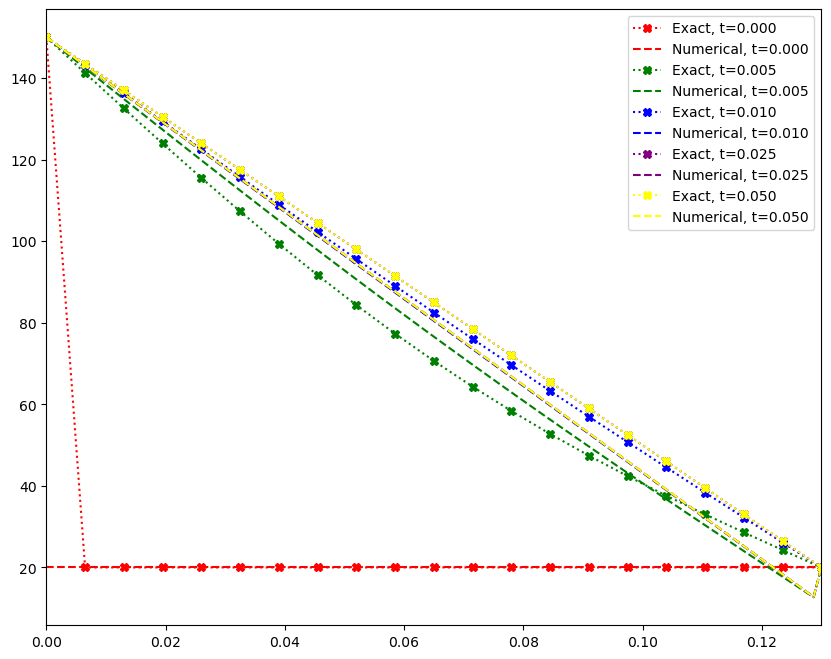

In [25]:
# Set parameters
Nt_gaps = 20000    # number of timesteps
T = 0.05             # final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step

Nx_spaces = 100;   # number of spaces in x
L = H; # Length of the can, 1 for now, will need to be changed but this will affect the exact solution as well
Nx_points = Nx_spaces + 1 
x = np.linspace(0, L, Nx_points)    # mesh points in space

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)

print("Delta x =", dx, "Delta t = ", dt, "C =", C)

# set up matrices for single time solutions and the full solution
u   = np.zeros(Nx_points)
u_old = np.zeros(Nx_points)

U = np.zeros((Nx_points,Nt_points))
U_ex = np.zeros((Nx_points, Nt_points))

# Data structures for the linear system
A = np.zeros((Nx_points, Nx_points))
b = np.zeros(Nx_points)

for i in range(1, Nx_points-1):
    A[i,i-1] = -C
    A[i,i+1] = -C
    A[i,i] = 1 + 2*C
    
# implement the (constant-in-time) Dirichlet conditions
A[0,0] = 1
A[Nx_points-1,Nx_points-1] = 1

# Set initial condition u(x,0) = I(x)
u_old[:] = I(x[:])

# initialise matrices for storing solutions
U[:,0] = u_old[:]
#U_ex[:,0] = U_exact(x,0)

# do timestepping 
for n in range(1, Nt_points):
    
    # Compute b and solve linear system
    b[1:Nx_points-2] = u_old[1: Nx_points-2]  # internal values
    b[0] = b0  # boundary conditions  
    b[-1] = bL

    # update u by solving the matrix system Au = b
    u_new = np.linalg.solve(A,b)
    
    # Update u_old before next step
    u_old = u_new
    U[:,n] = u_new
    #U_ex[:,n] = U_exact(x,t[n])

# plot snapshots of the solution
plotting(U, L)

BACKWARD EULER WITH SINK TERM

In [ ]:
##----------------------------------------------------------------------------------------------
##  BACKWARD EULER WITH SINK TERM
##  Mark's Code

# Boundary conditions
b0 = 150  # u(0,t)= b0
bL = 20   # u(L,t)= bL
a = 0.05 # heat transfer coefficient
u_inf = bL # air temp

# NOTE: Changed Nt_gaps to 20000 from 2000 for stable C value <=0.5
# Set parameters
Nt_gaps = 20000    # number of timesteps
T = 1              # final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step

Nx_spaces = 100   # number of spaces in x
L = 1 # Length of the can, 1 for now, will need to be changed but this will affect the exact solution as well
Nx_points = Nx_spaces + 1 
x = np.linspace(0, L, Nx_points)    # mesh points in space


# NOTE: stable solution for C<=0.5
#   C here is 5.0 when Nt_gaps = 2000 so Nt_gaps changed to 20000
    
dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)


# Initialize output

# Define the numerical solution 
# the first index is space and the second time
U = np.zeros((Nx_points,Nt_points))

# Set initial conditions (we use u_old to make our loop look nicer below)
u_old = np.zeros(Nx_points)
u_old[0] = b0
u_old[1:] = bL*np.ones(Nx_points-1)
U[:,0] = u_old[:]

# Data structures for the linear system: This will be used as AU_{t+1} = U_t (where U_t is b here) in the simulation
A = np.zeros((Nx_points, Nx_points))
b = np.zeros(Nx_points)

# This is from lectures
for i in range(1, Nx_points-1):
    A[i,i-1] = -C
    A[i,i+1] = -C
    A[i,i] = 1 + 2*C
    

# NOTE: Should the whole top row and bottom row be 1???
#   Currently: First cell of first column and last cell of last column are 1. 
#              The rest of the cells in the first and last rows are 0

# implement the (constant-in-time) Dirichlet conditions (i.e. the end points never change temp, U(0, t+dt) = U(0, t), same at x=1)
A[0,0] = 1 # NB: USE SCIPY SPARSE MATRIX FOR THIS
A[Nx_points-1,Nx_points-1] = 1


# NOTE: Might need to run this simulation without sink term to see if full can gets up to 80C like we need and note down time it reaches temp 
#   Will run with longer time horizon, ie set Nt_points higher and try this!

# Then we run the simulation. Easy!
# do timestepping (i.e. run simulation)
for n in range(1, Nt_points):
    b = u_old

    # update u by solving the matrix system Au = b
    u_new = np.linalg.solve(A,b) 
    u_new[1:Nx_points-1] -= a*(u_old[1:Nx_points-1] - u_inf) # I have done this because I don't want to subtract this from the end points, since the sink term does not apply there (endpoints are at a constant temp)
    
    # Update u_old before next step
    u_old = u_new
    U[:,n] = u_new
    
    
# Now we can plot our result for a given time t. You can vary t to see how the temperature distribution looks at various times.

# Plot our numeric U(x,t) at some given time t (note, t is in 1/Nt_points seconds, i.e. U[:, Nt_points] is the solution at time t=1)
t = Nt_points//2 # halfway thru the simulation
plt.plot(np.arange(0,1,1/Nx_points), U[:, t], label = f"{t=}")

plt.legend()
plt.show()

In [ ]:
##----------------------------------------------------------------------------------------------
##  Newton cooling at top of can
##  Jack's Code
##  x and t parameters and BC conditions same as above
##  For re-used parameters, ie A_nct and U, added "_nct" for newton cooling at top

Newton cooling at top of can

In [ ]:
##  Newton cooling at top of can
##  Jack's Code
##  x and t parameters and BC conditions same as above
##  For re-used parameters, ie A_nct and U, added "_nct" for newton cooling at top

# Heat transfer coefficient and ambient temperature
a = 0.05
h = 0.1  # heat transfer coefficient for Newton cooling (top boundary)


# Initialize matrices for storing solutions
U_nct = np.zeros((Nx_points, Nt_points))

# Define the tridiagonal matrix A_nct for the backward Euler scheme
A_nct = np.zeros((Nx_points, Nx_points))
for i in range(1, Nx_points - 1):
    A_nct[i, i - 1] = -C
    A_nct[i, i + 1] = -C
    A_nct[i, i] = 1 + 2 * C

# Implement boundary conditions
A_nct[0, 0] = 1  # Dirichlet condition at the bottom
A_nct[Nx_points - 1, Nx_points - 1] = 1 + h * dt / dx  # Newton cooling at the top


# NOTE: Sets bottom of can from 150C to 950C
#       top of can dropping lower than 20C because of cooling
#       set b0 to 150 to see what happens here when Newton cooling added
#       currently can only see what happens at 950C in data; all in plot
#       What we can investigate: what happens when bottom held at 150C and cooling term varies

# Set different bottom boundary conditions for investigation
b0_values = np.arange(150, 1001, 100)  # Different constant boundary values at x = 0 (bottom of the can)

for b0 in b0_values:
    # Set initial conditions
    u_old = 20 * np.ones(Nx_points)  # Initial temperature at t = 0
    u_old[0] = b0  # Set bottom boundary condition
    U_nct[:, 0] = u_old[:]

    # Time-stepping loop for the backward Euler method
    for n in range(1, Nt_points):
        # Set the boundary values in vector b
        b = u_old.copy()
        b[0] = b0  # Constant bottom boundary condition
        b[-1] = u_old[-1] + h * dt * (u_inf - u_old[-1]) / dx  # Newton cooling boundary condition at the top


# NOTE: Don't think we were meant to do this as it's unstable!!! Workshop 2 notes 
    
        # U_nctpdate u by solving the matrix system A_nct * u_new = b
        u_new = np.linalg.solve(A_nct, b)
        u_new[1:Nx_points - 1] -= a * (u_old[1:Nx_points - 1] - u_inf)  # A_nctpply heat transfer to the surrounding air

        # U_nctpdate u_old before the next step
        u_old = u_new
        U_nct[:, n] = u_new

    # Plot the temperature distribution at the final time step
    t_final = Nt_points - 1
    plt.plot(x, U_nct[:, t_final], label=f"Temperature at t = {T}, b0 = {b0}")

plt.xlabel("Position along the can (x)")
plt.ylabel("Temperature (u)")
plt.title("Temperature distribution along the can at final time for different bottom boundary conditions")
plt.legend()
plt.grid(True)
plt.show()

Newton cooling at bottom of can

In [ ]:
##  Newton cooling at bottom of can
##  Jamie's Code
##  adapted code from Jack
##  x and t parameters and BC conditions same as above
##  h: Heat transfer coefficient for Newton cooling at the bottom boundary. NB: Material dependent! 
##      SHOU_ncbLD BE SA_ncbME THROU_ncbGHOU_ncbT CODE U_ncbNLESS WE CHA_ncbNGE CA_ncbN MA_ncbTERIA_ncbLS
##  For re-used parameters, ie A_ncb and U_ncb, added "_ncb" for newton cooling at top
##  RESOURCE: https://uk.mathworks.com/help/simscape/ug/heat-conduction-through-iron-rod.html

# Initialize matrices for storing solutions
U_ncb = np.zeros((Nx_points, Nt_points))

# Define the tridiagonal matrix A_ncb for the backward Euler scheme
A_ncb = np.zeros((Nx_points, Nx_points))
for i in range(1, Nx_points - 1):
    A_ncb[i, i - 1] = -C
    A_ncb[i, i + 1] = -C
    A_ncb[i, i] = 1 + 2 * C

# Implement boundary conditions
A_ncb[0, 0] = 1 + h * dt / dx  # Newton cooling at bottom
A_ncb[Nx_points - 1, Nx_points - 1] = 1  # Dirichlet condition at top


# NOTE: Sets bottom of can from 150C to 950C
#       top of can dropping lower than 20C because of cooling
#       set b0 to 150 to see what happens here when Newton cooling added
#       currently can only see what happens at 950C
#       What we can investigate: what happens when bottom held at 150C and cooling term varies

# Set different bottom boundary conditions for investigation
b0_values = np.arange(150, 1001, 100)  # Different constant boundary values at x = 0 (bottom of the can)

for b0 in b0_values:
    # Set initial conditions
    u_old = 20 * np.ones(Nx_points)  # Initial temperature at t = 0
    u_old[0] = b0  # Set bottom boundary condition
    U_ncb[:, 0] = u_old[:]

    # Time-stepping loop for the backward Euler method
    for n in range(1, Nt_points):
        # Set the boundary values in vector b
        b = u_old.copy()
        #b[0] = b0  # Constant bottom boundary condition
        b[0] = u_old[0] + h * dt * (u_inf - u_old[0]) / dx  # Newton cooling boundary condition at the bottom

        # U_ncbpdate u by solving the matrix system A_ncb * u_new = b
        u_new = np.linalg.solve(A_ncb, b)
        u_new[1:Nx_points - 1] -= a * (u_old[1:Nx_points - 1] - u_inf)  # A_ncbpply heat transfer to the surrounding air

        # U_ncbpdate u_old before the next step
        u_old = u_new
        U_ncb[:, n] = u_new

    # Plot the temperature distribution at the final time step
    t_final = Nt_points - 1
    plt.plot(x, U_ncb[:, t_final], label=f"Temperature at t = {T}, b0 = {b0}")

plt.xlabel("Position along the can (x)")
plt.ylabel("Temperature (u)")
plt.title("Temperature distribution along the can at final time for different bottom boundary conditions")
plt.legend()
plt.grid(True)
plt.show()
